## 1st-level analysis (RED Go/No-go)

Adapted from Mengya's Script & nipype tutorial example: https://miykael.github.io/nipype_tutorial/notebooks/example_1stlevel.html

In this example, we will take the preprocessed output from the fMRIPrep and run for each subject a 1st-level analysis. For this we need to do the following steps:

0. Smooth the normalized result as fmriprep doesn't do this step
1. Extract onset times of stimuli from TVA file
2. Specify the model (TR, high pass filter, onset times, etc.)
3. Specify contrasts to compute
4. Estimate contrasts
5. Plot T- and beta-images


**Before you start**
Some participants have the same run twice (due to restart of the run), make sure to delete duplicates before run analysis

## Imports

First, we need to import all the modules we later want to use.

In [16]:
from nilearn import plotting
%matplotlib inline
from os.path import join as opj
import json
import numpy as np
from nipype.interfaces.spm import Smooth, Level1Design, EstimateModel, EstimateContrast
from nipype.algorithms.modelgen import SpecifySPMModel
from nipype.interfaces.utility import Function, IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.algorithms.misc import Gunzip
from nipype.pipeline.engine import MapNode
from nipype import Workflow, Node
# MATLAB - Specify path to current SPM and the MATLAB's default mode
from nipype.interfaces.matlab import MatlabCommand
MatlabCommand.set_default_paths('/imaging/su01/spm12')
MatlabCommand.set_default_matlab_cmd("matlab -nodesktop -nosplash")

## Experiment parameters

It's always a good idea to specify all parameters that might change between experiments at the beginning of your script.

In [18]:
# Set directories
bids_dir = '/imaging/su01/RED/bids'
experiment_dir = '/imaging/su01/RED/bids/derivatives/fmriprep-1.5.0/fmriprep'
output_dir = '/imaging/su01/RED/1stlevel_output_test6'
working_dir = '/imaging/su01/RED/1stlevel_workingdir_test6'

##note that you need to redefine directories within functions (define etc:)

###sub02 didn't have correct trials for most runs discard from analysis 
# list of subject identifiers

# Updated subject list to run for new contrasts
subject_list = ['002', '003', '005', '007', '008', '009',\
                '011', '012', '013','014', '015', '016', '017', '018',\
                '019', '024','025', '027', '029', '030', '035',\
                '037', '039', '040', '041', '044', '045', '047', '048',\
                '051', '053', '054', '055','058', '060', '062',\
                '064', '070', '072', '073', '075']

# these are the subjects without func preprocessing - seems to have had crash
# subject_list = ['015', '018', '039', '044', '047', '078']

# These are subjects with very noisy data (excluded from analysis for now)
# re-run participants with contrast issues
#subject_list = ['031', '036', '038', '050', '052', '056', '057', '069', '076', '078']  
# Additional subjects with bad framewise displacement average
subject_list = ['006', '010', '021', '048', '063', '077']

# TR of functional images
with open('/imaging/su01/RED/bids/sub-005/func/sub-005_task-task_bold.json', 'rt') as fp:
    task_info = json.load(fp)                                                 
TR = task_info['RepetitionTime']

# Smoothing kernel to use
fwhm = [6]

## Specify first level analysis pipeline & Nodes

Initiate all the different interfaces (represented as nodes) that you want to use in your workflow.

In [19]:
# Apply spatial smoothing first since fmriprep doesn't do this step
smoothing = Node(Smooth(fwhm= fwhm*3),
                name="smoothing")

## Now implement the nodes

#unzip nii.gz files
gunzip_con = MapNode(Gunzip(), name="gunzip_con", iterfield=['in_file'])

# SpecifyModel - Generates SPM-specific Model
modelspec = Node(SpecifySPMModel(concatenate_runs=False,
                                 input_units='secs',
                                 output_units='secs',
                                 time_repetition=TR,
                                 high_pass_filter_cutoff=128),
                 name="modelspec")

# Level1Design - Generates an SPM design matrix
level1design = Node(Level1Design(bases={'hrf': {'derivs': [1, 0]}},
                                 timing_units='secs',
                                 interscan_interval=TR,
                                 model_serial_correlations='AR(1)'),
                    name="level1design")

# EstimateModel - estimate the parameters of the model
level1estimate = Node(EstimateModel(estimation_method={'Classical': 1}),
                      name="level1estimate")

# EstimateContrast - estimates contrasts
level1conest = Node(EstimateContrast(), name="level1conest")

## Specify GLM contrasts

To do any GLM analysis, we need to also define the contrasts that we want to investigate. 

We have 8 conditions: 4 Go and 4 No-Go
- Sad Go; Sad NoGo
- Neutral Go; Neutral NoGo
- Happy Go; Happy NoGo
- Control Go; Control NoGo (scrambled faces)

These blocks are shown twice each for a total of 16 blocks
(In total though we have each emotion shown 4 times regardless of go/no-go type)

Main Effects
- Emotion
- Cognition (Response Inhibition)

Interaction
- Emotion x Go NoGo


#### From Mengya's script
With multiple regressors need to be careful with the rank efficiency of the model (should be full ranked) - 
check with function np.linalg.matrix_rank(design_matrix)


## T-tests (betas)

Run different chunks for different output folders to separate contrasts

<b>Main effects:</b> Go/NoGo, Faces, Emotion (valence - neutral/control)
- output folder (_main)

<b>Emotion</b>
- output folder (_emo)

<b>Go/NoGo</b>
- output folder (_go) & (_nogo)
- output folder for nogo vs go (_gng)

### _main

In [20]:
# For Main Effects

# Condition names
condition_names = ['s_n', 's_g', 'n_n', 'n_g', 'h_n', 'h_g', 'c_n', 'c_g']

# Contrasts
cont01 = ['Go > NoGo', 'T', condition_names, [-0.25, 0.25, -0.25, 0.25, -0.25, 0.25, -0.25, 0.25] ]
cont02 = ['NoGo > Go', 'T', condition_names, [0.25, -0.25, 0.25, -0.25, 0.25, -0.25, 0.25, -0.25] ]
cont03 = ['Faces > Control', 'T', condition_names, [1, 1, 1, 1, 1, 1, -3, -3]]
cont04 = ['Sad + Happy > Neutral', 'T', condition_names, [0.25, 0.25, -0.5, -0.5, 0.25, 0.25, 0, 0]]
cont05 = ['Sad + Happy > Control', 'T', condition_names, [0.25, 0.25, 0, 0, 0.25, 0.25, -0.5, -0.5]]
cont06 = ['Neutral > Sad + Happy', 'T', condition_names, [-0.25, -0.25, 0.5, 0.5, -0.25, -0.25, 0, 0]]
cont07 = ['Control > Sad + Happy', 'T', condition_names, [-0.25, -0.25, 0, 0, -0.25, -0.25, 0.5, 0.5]]


# Contrast list
contrast_list = [cont01, cont02, cont03, cont04, cont05, cont06, cont07]


### Only run if output directories are changed accordingly

### _emo

In [15]:
# For Emotion contrasts

# Condition names
condition_names = ['s_n', 's_g', 'n_n', 'n_g', 'h_n', 'h_g', 'c_n', 'c_g']

# Contrasts
cont01 = ['Sad > Happy', 'T', condition_names, [0.5, 0.5, 0, 0, -0.5, -0.5, 0, 0] ]
cont02 = ['Sad > Neutral', 'T', condition_names, [0.5, 0.5, -0.5, -0.5, 0, 0, 0, 0] ]
cont03 = ['Sad > Control', 'T', condition_names, [0.5, 0.5, 0, 0, 0, 0, -0.5, -0.5]]
cont04 = ['Happy > Sad', 'T', condition_names, [-0.5, -0.5, 0, 0, 0.5, 0.5, 0, 0]]
cont05 = ['Neutral > Sad', 'T', condition_names, [-0.5, -0.5, 0.5, 0.5, 0, 0, 0, 0]]
cont06 = ['Control > Sad', 'T', condition_names, [-0.5, -0.5, 0, 0, 0, 0, 0.5, 0.5]]
cont07 = ['Happy > Neutral', 'T', condition_names, [0, 0, -0.5, -0.5, 0.5, 0.5, 0, 0]]
cont08 = ['Happy > Control', 'T', condition_names, [0, 0, 0, 0, 0.5, 0.5, -0.5, -0.5]]
cont09 = ['Neutral > Happy', 'T', condition_names, [0, 0, 0.5, 0.5, -0.5, -0.5, 0, 0]]
cont10 = ['Control > Happy', 'T', condition_names, [0, 0, 0, 0, -0.5, -0.5, 0.5, 0.5]]
cont11 = ['Neutral > Control', 'T', condition_names, [0, 0, 0.5, 0.5, 0, 0, -0.5, -0.5]]
cont12 = ['Control > Neutral', 'T', condition_names, [0, 0, -0.5, -0.5, 0, 0, 0.5, 0.5]]

# Contrast list
contrast_list = [cont01, cont02, cont03, cont04, cont05, cont06, cont07, cont08, cont09, cont10, cont11, cont12]

### _go

In [ ]:
# For Go main contrasts

# Condition names
condition_names = ['s_n', 's_g', 'n_n', 'n_g', 'h_n', 'h_g', 'c_n', 'c_g']

# Contrasts
cont01 = ['Sad Go > Happy Go', 'T', condition_names, [0, 1, 0, 0, 0, -1, 0, 0] ]
cont02 = ['Sad Go > Neutral Go', 'T', condition_names, [0, 1, 0, -1, 0, 0, 0, 0] ]
cont03 = ['Sad Go > Control Go', 'T', condition_names, [0, 1, 0, 0, 0, 0, 0, -1] ]
cont04 = ['Happy Go > Sad Go', 'T', condition_names, [0, -1, 0, 0, 0, 1, 0, 0] ]
cont05 = ['Neutral Go > Sad Go', 'T', condition_names, [0, -1, 0, 1, 0, 0, 0, 0] ]
cont06 = ['Control Go > Sad Go', 'T', condition_names, [0, -1, 0, 0, 0, 0, 0, 1] ]
cont07 = ['Happy Go > Neutral Go', 'T', condition_names, [0, 0, 0, -1, 0, 1, 0, 0] ]
cont08 = ['Happy Go > Control Go', 'T', condition_names, [0, 0, 0, 0, 0, 1, 0, -1] ]
cont09 = ['Neutral Go > Happy Go', 'T', condition_names, [0, 0, 0, 1, 0, -1, 0, 0] ]
cont10 = ['Control Go > Happy Go', 'T', condition_names, [0, 0, 0, 0, 0, -1, 0, 1] ]
cont11 = ['Neutral Go > Control Go', 'T', condition_names, [0, 0, 0, 1, 0, 0, 0, -1] ]
cont12 = ['Control Go > Neutral Go', 'T', condition_names, [0, 0, 0, -1, 0, 0, 0, 1] ]

# Contrast list
contrast_list = [cont01, cont02, cont03, cont04, cont05, cont06, cont07, cont08, cont09, cont10, cont11, cont12]

### _nogo

In [ ]:
# For NoGo main contrasts

# Condition names
condition_names = ['s_n', 's_g', 'n_n', 'n_g', 'h_n', 'h_g', 'c_n', 'c_g']

# Contrasts
cont01 = ['Sad NoGo > Happy NoGo', 'T', condition_names, [1, 0, 0, 0, -1, 0, 0, 0] ]
cont02 = ['Sad NoGo > Neutral NoGo', 'T', condition_names, [1, 0, -1, 0, 0, 0, 0, 0] ]
cont03 = ['Sad NoGo > Control NoGo', 'T', condition_names, [1, 0, 0, 0, 0, 0, -1, 0] ]
cont04 = ['Happy NoGo > Sad NoGo', 'T', condition_names, [-1, 0, 0, 0, 1, 0, 0, 0] ]
cont05 = ['Neutral NoGo > Sad NoGo', 'T', condition_names, [-1, 0, 1, 0, 0, 0, 0, 0] ]
cont06 = ['Control NoGo > Sad NoGo', 'T', condition_names, [-1, 0, 0, 0, 0, 0, 1, 0] ]
cont07 = ['Happy NoGo > Neutral NoGo', 'T', condition_names, [0, 0, -1, 0, 1, 0, 0, 0] ]
cont08 = ['Happy NoGo > Control NoGo', 'T', condition_names, [0, 0, 0, 0, 1, 0, -1, 0] ]
cont09 = ['Neutral NoGo > Happy NoGo', 'T', condition_names, [0, 0, 1, 0, -1, 0, 0, 0] ]
cont10 = ['Control NoGo > Happy NoGo', 'T', condition_names, [0, 0, 0, 0, -1, 0, 1, 0] ]
cont11 = ['Neutral NoGo > Control NoGo', 'T', condition_names, [0, 0, 1, 0, 0, 0, -1, 0] ]
cont12 = ['Control NoGo > Neutral NoGo', 'T', condition_names, [0, 0, -1, 0, 0, 0, 1, 0] ]

# Contrast list
contrast_list = [cont01, cont02, cont03, cont04, cont05, cont06, cont07, cont08, cont09, cont10, cont11, cont12]

### _gng

In [22]:
# For Go vs NoGo

# Condition names
condition_names = ['s_n', 's_g', 'n_n', 'n_g', 'h_n', 'h_g', 'c_n', 'c_g']

# Contrasts
cont01 = ['Sad Go > Sad NoGo', 'T', condition_names, [-1, 1, 0, 0, 0, 0, 0, 0] ]
cont02 = ['Sad NoGo > Sad Go', 'T', condition_names, [1, -1, 0, 0, 0, 0, 0, 0] ]
cont03 = ['Happy Go > Happy NoGo', 'T', condition_names, [0, 0, 0, 0, -1, 1, 0, 0] ]
cont04 = ['Happy NoGo > Happy Go', 'T', condition_names, [0, 0, 0, 0, 1, -1, 0, 0] ]
cont05 = ['Neutral Go > Neutral NoGo', 'T', condition_names, [0, 0, -1, 1, 0, 0, 0, 0] ]
cont06 = ['Neutral NoGo > Neutral Go', 'T', condition_names, [0, 0, 1, -1, 0, 0, 0, 0] ]
cont07 = ['Control Go > Control NoGo', 'T', condition_names, [0, 0, 0, 0, 0, 0, -1, 1] ]
cont08 = ['Control NoGo > Control Go', 'T', condition_names, [0, 0, 0, 0, 0, 0, 1, -1] ]

# Contrast list
contrast_list = [cont01, cont02, cont03, cont04, cont05, cont06, cont07, cont08]

In [ ]:
# Try importing a mat file
# import pandas as pd
# from scipy.io import loadmat
# import os
#
# os.getcwd()
# test_mat = loadmat('/Users/stepheniuh/ownCloud/PhD/RED/Go-NoGo Data/GNG Task Data/sub-005_events.mat')
# test_mat

## Specify GLM model
Next step is to get info such as stimuli onset, duration, & other regressors into the GLM model.

This is where the helper function comes into play:
helper function ``subjectinfo``: grab run information from tsv file to create regressors


In [11]:
# For guidance, look at events file that was created fro events2tsv script
# !cat bids_dir + '/sub-005/func/sub-005_events.tsv'

# look at it as dataframe
import pandas as pd
trialinfo = pd.read_table(bids_dir + '/sub-002/func/sub-002_events.tsv')
trialinfo

,conditions,onset,duration,trial_type,emotion
0,h_g,1.775305,60,go,happy
1,c_g,71.359038,60,go,control
2,h_n,139.576288,60,nogo,happy
3,s_g,207.360029,60,go,sad
4,s_n,275.443909,60,nogo,sad
5,n_g,343.427804,60,go,neutral
6,n_n,413.344885,60,nogo,neutral
7,c_n,481.629022,60,nogo,control
8,h_n,555.429256,60,nogo,happy
9,h_g,623.663101,60,go,happy


In [12]:
# Separate onsets by condition
for group in trialinfo.groupby('conditions'):
    print(group)
    print("")

('c_g',    conditions       onset  duration trial_type  emotion
1         c_g   71.359038        60         go  control
12        c_g  829.747933        60         go  control)

('c_n',    conditions        onset  duration trial_type  emotion
7         c_n   481.629022        60       nogo  control
15        c_n  1037.382710        60       nogo  control)

('h_g',   conditions       onset  duration trial_type emotion
0        h_g    1.775305        60         go   happy
9        h_g  623.663101        60         go   happy)

('h_n',   conditions       onset  duration trial_type emotion
2        h_n  139.576288        60       nogo   happy
8        h_n  555.429256        60       nogo   happy)

('n_g',    conditions       onset  duration trial_type  emotion
5         n_g  343.427804        60         go  neutral
10        n_g  691.363504        60         go  neutral)

('n_n',    conditions       onset  duration trial_type  emotion
6         n_n  413.344885        60       nogo  neutral

In [21]:
# Incorporate above info in the helper function "subjectinfo"

def subjectinfo(subject_id):
    
    import glob
    import pandas as pd
    import numpy as np
    from nipype.interfaces.base import Bunch
    
    #Grab event files
    pattern = '/imaging/su01/RED/bids/sub-%s/func/sub-%s_events.tsv' % (subject_id, subject_id)
    path = sorted(glob.glob(pattern))
    ##print(path)
    assert len(path)>0, f"could not find subject for {pattern}"
        
    #Grab confound files
    pattern_confound = '/imaging/su01/RED/bids/derivatives/fmriprep-1.5.0/fmriprep/sub-%s/func/sub-%s*_task-task_desc-confounds_regressors.tsv' % (subject_id, subject_id)
    path_confound = sorted(glob.glob(pattern_confound))
    ##print (path_confound)
    
    subject_info=[]
    for i in range(len(path)):
        trialinfo = pd.read_table(path[i])
        conditions = []
        onsets = []
        durations = []
        
        #append target present/absent conditions into Bunch object
        for group in trialinfo.groupby('conditions'):
            conditions.append(group[0])
            onsets.append(np.round(group[1].onset.values,0).tolist())
            durations.append(np.round(group[1].duration.values,0).tolist())
        
        #below from Mengya's script but maybe group by emotion later
        #append correct/incorrect conditions into Bunch object
        #In case some runs subjects didn't make mistakes, assign a onset that's beyond the period of the run
#         for group in trialinfo.groupby('correct'):
#             if group[0]==0:
#                 conditions.append('incorrect')
#                 onsets.append(np.round(group[1].fixation_onset.values, 0).tolist())
#                 durations.append(np.round(group[1].duration.values,0).tolist())
#         if 'incorrect' not in conditions:
#             conditions.append('incorrect')#incase of no trial type exist, create a pseudo event 
#             onsets.append([12000.0])
#             durations.append([10.0])
        
        #confound parameters
        confounds =pd.read_csv(path_confound[i], sep="\t", na_values="n/a")
    
        subject_info.append(Bunch(conditions=conditions,
                              onsets=onsets,
                              durations=durations,
                              #pmod=None,
                              #Include motion regressors
                              regressors = [#list(confounds.FramewiseDisplacement.fillna(0)),
                                             list(confounds.trans_x),
                                            list(confounds.trans_y),
                                            list(confounds.trans_z),
                                            list(confounds.rot_x),
                                            list(confounds.rot_y),
                                            list(confounds.rot_z)
                               ],
                              regresssor_names=[#'FramewiseDisplacement',
                                                'X',
                                                'Y',
                                                'Z',
                                                'RotX',
                                                'RotY',
                                                'RotZ']
                               
                              #amplitudes=None,
                              #tmod=None,
                             ))

    return subject_info  # this output will later be returned to infosource

# Get Subject Info - get subject specific condition information
getsubjectinfo = Node(Function(input_names=['subject_id'],
                               output_names=['subject_info'],
                               function=subjectinfo),
                      name='getsubjectinfo')

## Specify input & output stream

Specify where the input data can be found & where and how to save the output data.

In [22]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id',
                                            'contrasts'],
                                    contrasts=contrast_list),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list)
                        ]

# SelectFiles - to grab the data (alternative to DataGrabber)
templates = {'func': experiment_dir + '/sub-' + '{subject_id}/func/*task-task*-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'}

selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")
selectfiles.inputs.task_id = 'go_nogo'


# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

# Use the following DataSink output substitutions
substitutions = [('_subject_id_', 'sub-')]

datasink.inputs.substitutions = substitutions



## Specify Workflow

Create a workflow and connect the interface nodes and the I/O stream to each other.

In [23]:
# Initiation of the 1st-level analysis workflow
l1analysis = Workflow(name='l1analysis')
l1analysis.base_dir = opj(experiment_dir, working_dir)

# Connect up the 1st-level analysis components
l1analysis.connect([(infosource, selectfiles, [('subject_id', 'subject_id')]),
                    (infosource, getsubjectinfo, [('subject_id',
                                                   'subject_id')]),
                    (selectfiles, gunzip_con, [('func', 'in_file')]),
                    (gunzip_con, smoothing, [('out_file',
                                             'in_files')]),
                    (smoothing, modelspec, [('smoothed_files',
                                            'functional_runs')]),
                    (getsubjectinfo, modelspec, [('subject_info',
                                                  'subject_info')]),
                    (infosource, level1conest, [('contrasts', 'contrasts')]),
                
                    (modelspec, level1design, [('session_info',
                                                'session_info')]),
                    (level1design, level1estimate, [('spm_mat_file',
                                                     'spm_mat_file')]),
                    (level1estimate, level1conest, [('spm_mat_file',
                                                     'spm_mat_file'),
                                                    ('beta_images',
                                                     'beta_images'),
                                                    ('residual_image',
                                                     'residual_image')]),
                    (level1conest, datasink, [('spm_mat_file', '1stLevel.@spm_mat'),
                                              ('spmT_images', '1stLevel.@T'),
                                              ('con_images', '1stLevel.@con'),
                                              ('spmF_images', '1stLevel.@F'),
                                              ('ess_images', '1stLevel.@ess'),
                                              ]),
                    ])



## Visualize the workflow

It always helps to visualize your workflow.

210216-13:54:16,903 nipype.workflow INFO:
	 Generated workflow graph: /imaging/su01/RED/1stlevel_workingdir_fwegng/l1analysis/graph.png (graph2use=colored, simple_form=True).


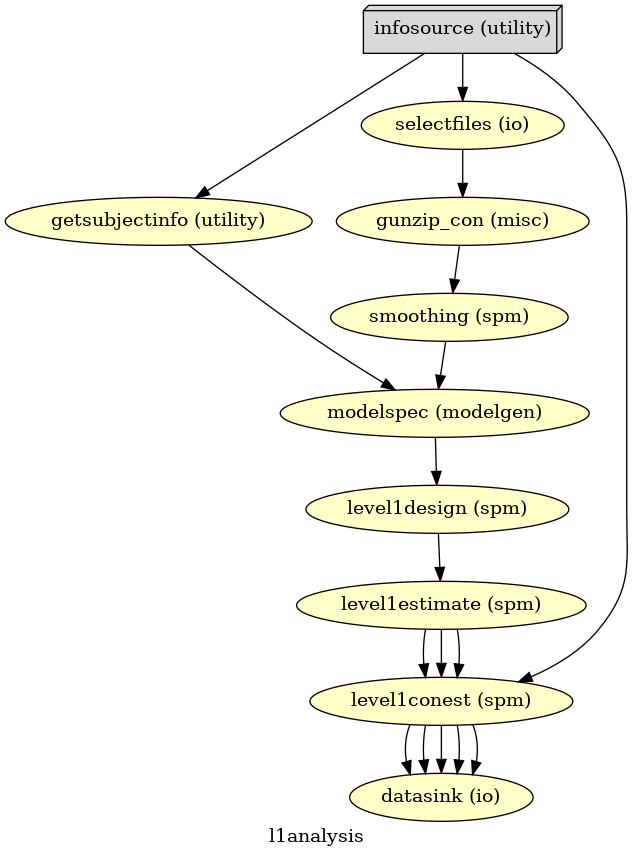

In [15]:
# Create 1st-level analysis output graph
l1analysis.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(l1analysis.base_dir, 'l1analysis', 'graph.png'))

##  Run the Workflow

Now that everything is ready, we can run the 1st-level analysis workflow. Change ``n_procs`` to the number of jobs/cores you want to use.

In [24]:
l1analysis.run('MultiProc', plugin_args={'n_procs': 16})

210217-22:44:34,822 nipype.workflow INFO:
	 Workflow l1analysis settings: ['check', 'execution', 'logging', 'monitoring']
210217-22:44:34,910 nipype.workflow INFO:
	 Running in parallel.
210217-22:44:34,921 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 12 jobs ready. Free memory (GB): 113.14/113.14, Free processors: 16/16.
210217-22:44:35,142 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.getsubjectinfo" in "/imaging/su01/RED/1stlevel_workingdir_test6/l1analysis/_subject_id_077/getsubjectinfo".
210217-22:44:35,145 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.getsubjectinfo" in "/imaging/su01/RED/1stlevel_workingdir_test6/l1analysis/_subject_id_063/getsubjectinfo".
210217-22:44:35,144 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.selectfiles" in "/imaging/su01/RED/1stlevel_workingdir_test6/l1analysis/_subject_id_077/selectfiles".
210217-22:44:35,147 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.getsubjectinfo" in "/imaging/su01/RED/1stlevel_wor

In [ ]:
# To check the crash file saved from run attempt
# edit crash file name at the end to pick whichever one 
!nipypecli crash /imaging/su01/RED/scripts/crash-20210215-230236-su01-getsubjectinfo.a34-e35e40ac-bad3-4568-8306-21ea795cfe5e.pklz


## Inspect output

Let's check the structure of the output folder, to see if we have everything we wanted to save. You should have nine contrast images (``con_*.nii`` for T-contrasts and ``ess_*.nii`` for T-contrasts) and nine statistic images (``spmT_*.nii`` and ``spmF_*.nii``) for every subject and smoothing kernel.

In [ ]:
!tree /imaging/su01/RED/1stlevel_output/1stLevel/

## Visualize results

Let's look at the contrasts of one subject that we've just computed. First, let's see what the difference of smoothing is for the contrast **`average`**

In [ ]:
from nilearn import plotting
sub = '005'
anatimg = experiment_dir + '/sub-%s/anat/sub-%s_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz' % (sub,sub)

In [ ]:
plotting.plot_stat_map(
    '/imaging/su01/RED/1stlevel_output/1stLevel/sub-%s/spmT_0001.nii'%(sub), title='average_sub%s'%sub,
    bg_img=anatimg, threshold=2, display_mode='ortho');

In [ ]:
view = plotting.view_img(output_dir + '/1stLevel/sub-%s/spmT_0001.nii'%(sub), bg_img = anatimg,
                         title='Tmap_NoGovsGo_sub%s'%sub, threshold=3)
view

Look at contrasts

In [ ]:
plotting.plot_stat_map(output_dir + '/1stLevel/sub-%s/spmT_0001.nii'%(sub), 
              bg_img = anatimg, title='Tmap_NoGovsGo_sub%s'%sub, 
              threshold=3, display_mode='y', cut_coords=(-5, 0, 5, 10, 15), 
              dim=-1)


Interactive image

In [ ]:
view = plotting.view_img(output_dir + '/1stLevel/sub-%s/spmT_0001.nii'%(sub), bg_img = anatimg,
                         title='Tmap_NoGovsGo_sub%s'%sub, display_mode = 'y', cut_coords=(-14,-67,51),threshold=3)
view

# Visualize design matrix


In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

First, let's look at the 1st-level Design Matrix of subject 005, to verify that everything is as it should be.


In [ ]:
from scipy.io import loadmat

# To look at interaction...

#Set working directory from local computer just to check
local_output_dir = '/Users/stepheniuh/ownCloud/PhD/RED'
sub = '005'

# Using scipy's loadmat function we can access SPM.mat
spmmat = loadmat(local_output_dir + '/sub-%s/SPM.mat'%sub,
                 struct_as_record=False)
#access the matrix and name of regressors
designMatrix = spmmat['SPM'][0][0].xX[0][0].X
names = [i[0] for i in spmmat['SPM'][0][0].xX[0][0].name[0]]

#Now before we can plot it, we just need to normalize the desing matrix in such a way, 
#that each column has a maximum amplitude of 1. This is just for visualization purposes, 
#otherwise the rotation parameters with their rather small values will not show up in the figure.
normed_design = designMatrix / np.abs(designMatrix).max(axis=0)
fig, ax = plt.subplots(figsize=(12, 12))
plt.imshow(normed_design, aspect='auto', cmap='gray', interpolation='none')
ax.set_ylabel('Volume id')
ax.set_xticks(np.arange(len(names)))
ax.set_xticklabels(names, rotation=90);

In [ ]:
import nibabel as nb
from nilearn.plotting import plot_anat
from nilearn.plotting import plot_glass_brain
%matplotlib inline

In [ ]:
plot_glass_brain(local_output_dir + '/sub-%s/ess_0004.nii'%sub,
                 colorbar=True, display_mode='lyrz', black_bg=True, threshold=25,
                 title='subject 5 - F-contrast: Emo x GoNogo');